# Cluster analysis on geo-spatial data

## Task: detect significant travel points (i.e., in simple terms, places where we have stayed longer)

Visualize the results.

Download coordinates of European cities from http://www.clearlyandsimply.com/clearly_and_simply/2010/10/geocoding-databases-for-europe.html and assign cities to points.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import sqlite3

In [2]:
data = pd.read_csv("summer-travel-gps-full-2.csv")
data.head()

,lat,lon
0,51.481292,-0.451011
1,51.474005,-0.450999
2,51.478199,-0.446081
3,51.478199,-0.446081
4,51.474146,-0.451562


In [4]:
eu = pd.read_csv('european_cities_and_postcodes_us_standard/european_cities_us_standard.csv')
eu.head()

,European City,Country (ISO 3166-2),Latitude,Longitude
0,Andorra la Vella,AD,42.5000,1.5000
1,Canillo,AD,42.5833,1.6667
2,Encamp,AD,42.5333,1.6333
3,Escaldes-Engordany,AD,42.5000,1.5667
4,La Massana,AD,42.5667,1.4833


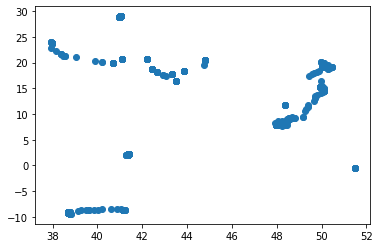

In [3]:
plt.scatter(data['lat'], data['lon'])

In [16]:
def run_dbscan(data, eps, min_samples):
    # Fit model
    model = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    labels = model.fit_predict(data)
    
    # Plot simple results
    plt.scatter(data['lat'], data['lon'], c=labels+1, alpha=0.2)
    plt.show()
    
    # Add labels to data
    data_with_labels = data.copy()
    data_with_labels['label'] = labels
    
    return data_with_labels

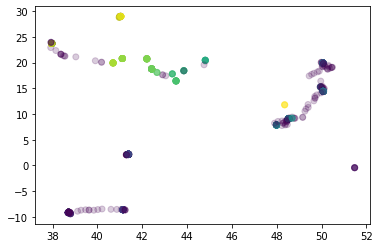

In [20]:
data_with_labels = run_dbscan(data, 0.01, 5)

In [21]:
def aggregate_results(data_with_labels):
    cities_found = data_with_labels.groupby('label').agg(['min', 'max'])
    cities_found.columns = ['lat_min', 'lat_max', 'lon_min', 'lon_max']
    cities_found.drop(-1, inplace=True)  # Drop noisy samples
    return cities_found

In [15]:
cities_found = aggregate_results(data2)
cities_found

,lat_min,lat_max,lon_min,lon_max
label,,,,
0,38.706345,38.725219,-9.148578,-9.113374
1,38.691944,38.700239,-9.215561,-9.201724
2,41.136531,41.152035,-8.621177,-8.606416
3,41.354599,41.411740,2.110420,2.191613
4,50.046936,50.068953,19.929263,19.954828
5,50.063902,50.094667,14.388349,14.454115
6,49.937352,49.967551,15.261668,15.290416
7,48.509353,48.528542,9.035939,9.077395
8,47.985623,47.999278,7.839214,7.890262


In [11]:
eu.head(2)

,European City,Country (ISO 3166-2),Latitude,Longitude
0,Andorra la Vella,AD,42.5000,1.5000
1,Canillo,AD,42.5833,1.6667


In [25]:
def recognize_cities(cities_found):
    # Create virtual db and table
    conn = sqlite3.connect(':memory:')
    cities_found.to_sql('cities_found', conn, index=False)
    eu.to_sql('eu', conn, index=False)

    # Utilize sql's "BETWEEN" to recognize cities inside clusters found
    qry = '''
        SELECT  
            a.lat_min, a.lat_max, a.lon_min, a.lon_max,
            b.'European City', b.Latitude, b.Longitude
        FROM
            cities_found as a
                LEFT JOIN eu as b
                ON (b.Latitude BETWEEN a.lat_min and a.lat_max) 
                AND (b.Longitude BETWEEN a.lon_min and a.lon_max)
        '''
    df = pd.read_sql_query(qry, conn)
    conn.close()
    return df

In [26]:
df = recognize_cities(cities_found)
df

C:\Users\jp_ko\Anaconda3\lib\site-packages\pandas\core\generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


,lat_min,lat_max,lon_min,lon_max,European City,Latitude,Longitude
0,38.706345,38.725219,-9.148578,-9.113374,Lisboa,38.716819,-9.133492
1,38.706345,38.725219,-9.148578,-9.113374,Sobreda,38.709579,-9.132704
2,38.691944,38.700239,-9.215561,-9.201724,None,NaN,NaN
3,41.136531,41.152035,-8.621177,-8.606416,Porto,41.150021,-8.616716
4,41.354599,41.411740,2.110420,2.191613,Barcelona,41.389611,2.166118
5,41.354599,41.411740,2.110420,2.191613,Sant Adria De Besos,41.385500,2.178600
6,50.046936,50.068953,19.929263,19.954828,None,NaN,NaN
7,50.063902,50.094667,14.388349,14.454115,Kopaniny,50.094433,14.388867
8,50.063902,50.094667,14.388349,14.454115,Praha 5-Smchov (?st) x),50.093050,14.390300
9,50.063902,50.094667,14.388349,14.454115,Smchov (?st),50.093050,14.390300


### Second approach: _eps=0.02, min_samples=10_
Increase both parameters to catch bigger cities / clouds of points with bigger dispersion.

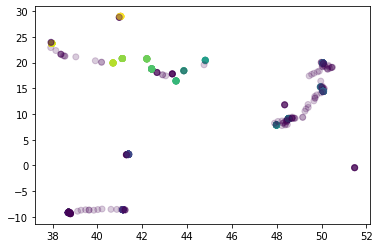

C:\Users\jp_ko\Anaconda3\lib\site-packages\pandas\core\generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


,lat_min,lat_max,lon_min,lon_max,European City,Latitude,Longitude
20,37.966766,37.989225,23.719678,23.740194,None,NaN,NaN
2,38.691944,38.700239,-9.215561,-9.201724,None,NaN,NaN
0,38.706345,38.725219,-9.148578,-9.113374,Lisboa,38.716819,-9.133492
1,38.706345,38.725219,-9.148578,-9.113374,Sobreda,38.709579,-9.132704
19,40.702179,40.703946,19.946288,19.953365,None,NaN,NaN
21,41.001629,41.044556,28.949191,29.006664,Istanbul,41.019382,28.964855
18,41.111061,41.116809,20.790185,20.799085,None,NaN,NaN
3,41.136531,41.152035,-8.621177,-8.606416,Porto,41.150021,-8.616716
4,41.354599,41.411740,2.110420,2.191613,Barcelona,41.389611,2.166118
5,41.354599,41.411740,2.110420,2.191613,Sant Adria De Besos,41.385500,2.178600


In [27]:
data_with_labels = run_dbscan(data, eps=0.02, min_samples=10)
cities_found = aggregate_results(data_with_labels)
df = recognize_cities(cities_found)
df.sort_values(['lat_min', 'lat_max', 'lon_min', 'lon_max'])

### Remove locations being suburbs of bigger cities

In [ ]:
df = df[df['European City'].isin(['Kopaniny', 'Smchov (?st)', 'Sant Adria De Besos', 'Sobreda'])==False]
df['European City'].replace({'Praha 5-Smchov (?st) x)': 'Praga'}, inplace=True)

In [28]:
from sklearn.metrics import pairwise_distances_argmin

In [29]:
df3 = df[df['European City'].isna()][['lat_min', 'lat_max', 'lon_min', 'lon_max']].copy()
df3['lat_mean'] = df3[['lat_min', 'lat_max']].mean(axis=1)
df3['lon_mean'] = df3[['lon_min', 'lon_max']].mean(axis=1)

In [30]:
pairwise_distances_argmin(
                                df3[['lat_mean', 'lon_mean']],
                                eu[['Latitude', 'Longitude']])

array([224297, 218587, 187073, 189542, 190166, 190987, 212766, 212836,
       212853, 251794], dtype=int64)

In [31]:
eu['European City'][pairwise_distances_argmin(
                                df3[['lat_mean', 'lon_mean']],
                                eu[['Latitude', 'Longitude']])].values

array(['Capuchos', 'Krakw', 'Ilok', 'Pridvorje', 'Split', 'Vitaljina',
       'Golema Recica', 'Ohrid', 'Radolista', 'Cesme'], dtype=object)

In [32]:
df3['City2'] = eu['European City'][pairwise_distances_argmin(
                                df3[['lat_mean', 'lon_mean']],
                                eu[['Latitude', 'Longitude']])].values

### Plot findings!

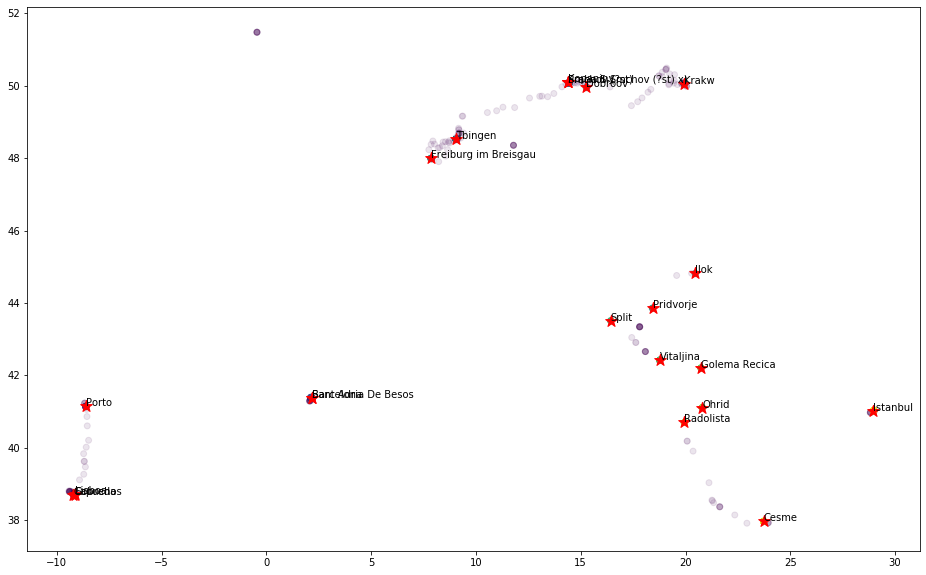

In [34]:
plt.figure(figsize=(16, 10))
plt.scatter(data['lon'], data['lat'], c=labels+1, alpha=0.1)

city_coords = df[df['European City'].isna()==False][['European City', 'Latitude', 'Longitude']]

city_coords.reset_index(inplace=True)

plt.scatter(city_coords['Longitude'], city_coords['Latitude'], color='red', marker='*', s=150)
plt.scatter(df3['lon_mean'], df3['lat_mean'], color='red', marker='*', s=150)

for i, city_name in enumerate(city_coords['European City']):
    plt.annotate(city_name, (city_coords.loc[i, 'Longitude'], city_coords.loc[i, 'Latitude']))

for i, city_name in enumerate(df3['City2']):
    plt.annotate(city_name, (df3.iloc[i]['lon_mean'], df3.iloc[i]['lat_mean']))

In [35]:
eu[eu['European City'].str.startswith('Belgr')]

,European City,Country (ISO 3166-2),Latitude,Longitude
162978,Belgrave,GB,52.6500,-1.1167
162979,Belgravia,GB,51.4963,-0.1553
185223,Belgrad,HR,45.2167,14.7333


In [175]:
df[df['European City'].isna()]

,lat_min,Latitude,lat_max,lon_min,Longitude,lon_max,European City
2,38.691944,NaN,38.700239,-9.215561,NaN,-9.201724,None
6,50.046936,NaN,50.068953,19.929263,NaN,19.954828,None
13,44.814209,NaN,44.820414,20.462994,NaN,20.464091,None
14,43.859459,NaN,43.859534,18.425865,NaN,18.425966,None
15,43.504722,NaN,43.511184,16.434196,NaN,16.443532,None
16,42.423295,NaN,42.424410,18.771216,NaN,18.771708,None
17,42.208071,NaN,42.209631,20.735993,NaN,20.741421,None
18,41.111061,NaN,41.116809,20.790185,NaN,20.799085,None
19,40.702179,NaN,40.703946,19.946288,NaN,19.953365,None
20,37.966766,NaN,37.989225,23.719678,NaN,23.740194,None


In [178]:
from sklearn.metrics import pairwise_distances_argmin

eu.iloc[:, 0][pairwise_distances_argmin(
    data.groupby(model.labels_).mean().iloc()[1:],
    eu.iloc[:, -2:])]

242443                 Sobreda
224297                Capuchos
237841                   Porto
74504                Barcelona
218587                   Krakw
54324                Vinohrady
45920                  Dobroov
66775                  Tbingen
58326     Freiburg im Breisgau
187073                    Ilok
189542               Pridvorje
190166                   Split
190987               Vitaljina
212766           Golema Recica
212836                   Ohrid
212853               Radolista
251794                   Cesme
252168                Istanbul
Name: European City, dtype: object

In [185]:
eu['European City'][pairwise_distances_argmin(
                                df3[['lat_mean', 'lon_mean']],
                                eu[['Latitude', 'Longitude']])].values

224297         Capuchos
218587            Krakw
187073             Ilok
189542        Pridvorje
190166            Split
190987        Vitaljina
212766    Golema Recica
212836            Ohrid
212853        Radolista
251794            Cesme
Name: European City, dtype: object